## Домашнее задание №2 (построение собственных сетей CNN + FFN)

#### Настя Шабаева, БКЛ181

### Импорт необходимого

In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import ipdb
from torchmetrics import F1
from torchmetrics.functional import f1, recall, accuracy, precision

import gensim

import matplotlib.pyplot as plt

### Предобработка данных

Данные я скачала отдельно (два файла 'positive.csv' и 'negative.csv'). Сначала достаем данные из файла (берем только сам текст и тон (положительный твит или отрицательный)) и объединяем все данные в одну переменную

In [2]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [3]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


Перемешиваем данные и берем только первые 100000 твитов

In [4]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

Делим выборку на обучающую и тестовую (в соотношении 9 к 1). Дальше пример первых 10 твитов обучающей выборки.

In [5]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [6]:
train_sentences[:10]

,text,tone
21745,RT @massquerrade: @MeetPrettyShit твой юн &lt;...,1
32399,@serialfandom @iamsolitude ладно я хочу спать....,1
13383,@Ricosmosss да вообщем ничего важного с: мне н...,1
24014,RT @Odkhuu_D: @nominod багшийг дуурайгаарай:) ...,1
95622,"@syn_thesi_zer ахаха, нет, я просто опоздал сн...",1
68939,RT @kota_Oo_oO: @loss_courage #Снаступающимтви...,0
110492,@RadiopAshA Ну не испокон. Только в этом тысяч...,1
90556,RT @_Do_or_Die__: скорость меньше\nчем у джаст...,0
90928,Каждый вечер об этом говорю:D да на самом деле...,1
57240,"Как сказал Артём Фомичев, что колонка скоро бу...",1


Функция простейшего препроцессинга текстов: делим твиты на токены, приводим к нижнему регистру и удаляем всю пунктуацию.

In [7]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

Создаем словарь уникальных токенов, а потом оставляем только те токены, которые встретились больше 2 раз

In [8]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 202799


In [9]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 32470


Создаем словарь, в ключах которого токены (встретившиеся больше 2 раз), в значениях их индексы word2id, для спецсимвола паддинга дефолтный индекс - 0

In [10]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [11]:
print(len(word2id))

32471


Создаем обратный словарь для того, чтобы раскодировать последовательность

In [12]:
id2word = {i:word for word, i in word2id.items()}

Если возможно, просим торч использовать gpu.

In [13]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

## Архитектура I
### Приведение данных в вид, подходящий для "отправки" в нейросеть

Приводим данные в такой вид, чтобы их потом можно было отдать нейросети. То есть создаем класс TweetsDataset, наследующийся от Dataset. В нем есть несколько обязательных методов, метод, который делает минимальный препроцессинг текста (отдельно такой метод уже создавался, когда собирали словарь word2id), и метод, в котором добавляются паддинги, в котором значения, которые мы будем предсказваться, представяляюся в виде тензора).

In [14]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
        y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
        return padded_ids, y

Для обучающей и для тестовой выборки создаем экземпляры Dataset (точнее того, класса, который наследует от него) и DataLoader

In [15]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [16]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

### Создаем саму модель

В ней сначала создаются эмбеддинги; затем идут 2 разных сверточных слоя (в каждом разное количество фильтров и разный шаг у этих фильтров: на первом слое шаг - 2, на втором - 3; затем идет слой пуллинга; потом первая функция активации - ReLU, дальше скрытый линейный слой, сокращающий количество выходных нейронов до 1; после этого дропаут; а в конце вторая функция активации - сигмоида, которая выдает нам в результате вероятность. 

In [17]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.next_conv = nn.Conv1d(in_channels=180, out_channels=90, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=90, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        # batch_size x seq_len
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        # batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
    
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #batch_size x filter_count3 x seq_len*

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)  # конкатенация "биграм" и "тиграм"
        next_conv = self.dropout(self.relu(self.next_conv(concat)))
        
        pooling = next_conv.max(2)[0]
        
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

### Функции обучения и эвалюации 

В первой функции модель обучается: ходим по данным внутри батчей, подсчитываем градиенты, на их основе обновляем веса.

In [18]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


В этой функции, можно сказать, происходит оценка модели: перемещаясь по батчам, по предсказаниям на тестовых данных считаем функцию потерь, f1, accuracy, precision и recall.

In [19]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric_f1 = 0
    epoch_metric_precision = 0
    epoch_metric_recall = 0
    epoch_metric_accuracy = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric_f1 = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric_f1 += batch_metric_f1
            batch_metric_precision = precision(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric_precision += batch_metric_precision
            batch_metric_recall = recall(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric_recall += batch_metric_recall
            batch_metric_accuracy = accuracy(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric_accuracy += batch_metric_accuracy

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric_f1/i}, \nVal accuracy: {epoch_metric_accuracy/i}, Val precision: {epoch_metric_precision/i}, Val recall: {epoch_metric_recall/i}\n')
        
    return epoch_metric_f1 / len(iterator), epoch_metric_accuracy / len(iterator), epoch_metric_precision / len(iterator), epoch_metric_recall / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

Задаем саму модель - экземпляр только что созданного класса

In [20]:
model = CNN(len(word2id), 180)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

Запускаем обучение и эвалюацию модели (на 20 эпохах)

In [21]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracies_eval = []
precisions = []
precisions_eval = []
recalls = []
recalls_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train, accuracy_on_train, precision_on_train, recall_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    precisions.append(precision_on_train)
    recalls.append(recall_on_train)
    print('\nEvaluating on test...')
    f1_on_test, accuracy_on_test, precision_on_test, recall_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracies_eval.append(accuracy_on_test)
    precisions_eval.append(precision_on_test)
    recalls_eval.append(recall_on_test)


starting Epoch 0
Training...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.7704554907977581
Train loss: 0.7223148634939482
Train loss: 0.699070714712143
Train loss: 0.6841595306325314
Train loss: 0.6730034599701563

Evaluating on train...
Val loss: 0.6582629196345806, Val f1: 0.6918991804122925, 
Val accuracy: 0.6830806136131287, Val precision: 0.7013741731643677, Val recall: 0.6830806136131287

Val loss: 0.6376629598212965, Val f1: 0.6731104850769043, 
Val accuracy: 0.6633949875831604, Val precision: 0.6836104393005371, Val recall: 0.6633949875831604

Val loss: 0.6302162182331085, Val f1: 0.6693253517150879, 
Val accuracy: 0.6574370861053467, Val precision: 0.6820591688156128, Val recall: 0.6574370861053467

Val loss: 0.6267329454421997, Val f1: 0.6647940874099731, 
Val accuracy: 0.6516832709312439, Val precision: 0.6789161562919617, Val recall: 0.6516832709312439

Val loss: 0.6239372733093443, Val f1: 0.6641789674758911, 
Val accuracy: 0.6513563394546509, Val precision: 0.6779831051826477, Val recall: 0.6513563394546509


Evaluating on test...


Evaluating on test...
Val loss: 1.0457107424736023, Val f1: 1.504270076751709, 
Val accuracy: 1.5060126781463623, Val precision: 1.502761960029602, Val recall: 1.5060126781463623

Val loss: 0.7027666171391805, Val f1: 0.9875805974006653, 
Val accuracy: 0.978668212890625, Val precision: 0.9972378611564636, Val recall: 0.978668212890625

Val loss: 0.6322793006896973, Val f1: 0.8890813589096069, 
Val accuracy: 0.8852168321609497, Val precision: 0.8934076428413391, Val recall: 0.8852168321609497

Val loss: 0.6044707979474749, Val f1: 0.8466736674308777, 
Val accuracy: 0.8427045941352844, Val precision: 0.8510618209838867, Val recall: 0.8427045941352844

Val loss: 0.5899500979317559, Val f1: 0.819106936454773, 
Val accuracy: 0.8125406503677368, Val precision: 0.8261825442314148, Val recall: 0.8125406503677368


starting Epoch 5
Training...
Train loss: 0.4760701283812523
Train loss: 0.46185498255671875
Train loss: 0.4573148959875107
Train loss: 0.4529264738310629
Train loss: 0.4525695028049

Train loss: 0.3523237949067896
Train loss: 0.35012500286102294
Train loss: 0.3514133736268798
Train loss: 0.35275447581495556

Evaluating on train...
Val loss: 0.3672451600432396, Val f1: 0.9237116575241089, 
Val accuracy: 0.8911290168762207, Val precision: 0.9590432643890381, Val recall: 0.8911290168762207

Val loss: 0.35399877483194525, Val f1: 0.8970213532447815, 
Val accuracy: 0.865120530128479, Val precision: 0.9316484928131104, Val recall: 0.865120530128479

Val loss: 0.35224091708660127, Val f1: 0.8876185417175293, 
Val accuracy: 0.856606662273407, Val precision: 0.9212322235107422, Val recall: 0.856606662273407

Val loss: 0.3496094243739968, Val f1: 0.8838041424751282, 
Val accuracy: 0.85284024477005, Val precision: 0.917352020740509, Val recall: 0.85284024477005

Val loss: 0.34774128028324675, Val f1: 0.8813531994819641, 
Val accuracy: 0.8509013652801514, Val precision: 0.9143190979957581, Val recall: 0.8509013652801514


Evaluating on test...
Val loss: 0.9971407055854797, Val


Evaluating on test...
Val loss: 1.0518206357955933, Val f1: 1.5017309188842773, 
Val accuracy: 1.5155987739562988, Val precision: 1.488114833831787, Val recall: 1.5155987739562988

Val loss: 0.7376843690872192, Val f1: 0.989044189453125, 
Val accuracy: 0.9875094294548035, Val precision: 0.9911114573478699, Val recall: 0.9875094294548035

Val loss: 0.6590381145477295, Val f1: 0.8917614221572876, 
Val accuracy: 0.8953601717948914, Val precision: 0.8886352777481079, Val recall: 0.8953601717948914

Val loss: 0.6309866224016462, Val f1: 0.8509946465492249, 
Val accuracy: 0.8515380024909973, Val precision: 0.851162850856781, Val recall: 0.8515380024909973

Val loss: 0.612016068564521, Val f1: 0.8247178196907043, 
Val accuracy: 0.8236284255981445, Val precision: 0.8264615535736084, Val recall: 0.8236284255981445


starting Epoch 14
Training...
Train loss: 0.27499531768262386
Train loss: 0.26894883811473846
Train loss: 0.27068905502557755
Train loss: 0.27165180555920104
Train loss: 0.27329856

Train loss: 0.2239192579731797
Train loss: 0.22503677010536194
Train loss: 0.22447892734363897
Train loss: 0.22499036824419386

Evaluating on train...
Val loss: 0.2189465295523405, Val f1: 0.9947060346603394, 
Val accuracy: 0.9790745973587036, Val precision: 1.0109652280807495, Val recall: 0.9790745973587036

Val loss: 0.2108605160857692, Val f1: 0.9647380709648132, 
Val accuracy: 0.9477851390838623, Val precision: 0.9824495315551758, Val recall: 0.9477851390838623

Val loss: 0.2061452803015709, Val f1: 0.9571169018745422, 
Val accuracy: 0.9417198896408081, Val precision: 0.9731622338294983, Val recall: 0.9417198896408081

Val loss: 0.20512474472842998, Val f1: 0.9520597457885742, 
Val accuracy: 0.9373267292976379, Val precision: 0.9673988223075867, Val recall: 0.9373267292976379

Val loss: 0.20486970618367195, Val f1: 0.9489858746528625, 
Val accuracy: 0.9343237280845642, Val precision: 0.9642491936683655, Val recall: 0.9343237280845642


Evaluating on test...
Val loss: 1.200687229633

In [22]:
print(losses, '\n\n', losses_eval)

[0.6635696217417717, 0.5970789282159372, 0.5540223196148872, 0.5137656889855862, 0.48048213056542655, 0.4471133510497483, 0.41876637088981544, 0.39315483143383806, 0.36837342008948326, 0.34866856986826117, 0.33041208305142145, 0.3110760243778879, 0.2979169152677059, 0.28078451701863244, 0.2708579692989588, 0.25562297231094405, 0.24401857432993976, 0.23331775990399448, 0.22273892858488994, 0.21320214291865175] 

 [0.6192739009857178, 0.5901781141757965, 0.564483106136322, 0.546650356054306, 0.5309550881385803, 0.5218810141086578, 0.5149481654167175, 0.5135581523180008, 0.5133891612291336, 0.5177835434675216, 0.5240181297063827, 0.5286054760217667, 0.5396590411663056, 0.5508144617080688, 0.5649224698543549, 0.5891725838184356, 0.6059382021427154, 0.6238153576850891, 0.6537458777427674, 0.6752877533435822]


Модель обучается, но кажется, в какой-то момент переобучается, поскольку, например, к 20й эпохе средний loss на обучающей выборке - примерно 0.21, а на тестовой - 0.68. Попробую сделать модель с предобученными эмбеддингами и посмотреть, поменяет ли это как-то ситуацию.

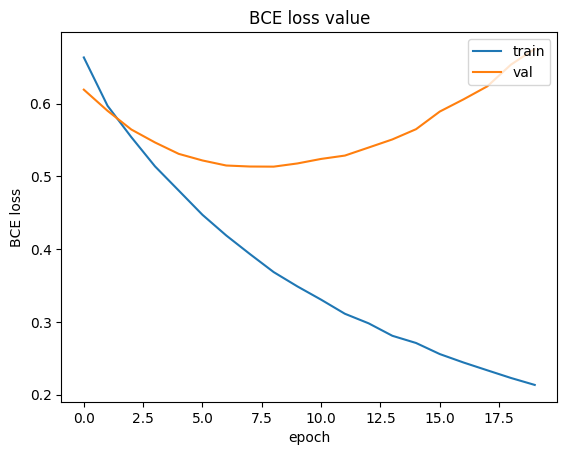

In [23]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Модель с предобученными эмбеддингами
Создаем модель Word2Vec и создаем с её помощью матрицу весов, которые потом будем передавать в модель CNN

In [24]:
texts = all_tweets_data.text.apply(preprocess).tolist()
w2v = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1)

weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
        count += 1
        # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,100)

Сама модель CNN (такая же как прошлая, только с предобученными эмбеддингами)

In [25]:
class CNN_w2v(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.next_conv = nn.Conv1d(in_channels=180, out_channels=90, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=90, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        # batch_size x seq_len
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        # batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
    
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #batch_size x filter_count3 x seq_len*

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)  # конкатенация "биграм" и "тиграм"
        next_conv = self.dropout(self.relu(self.next_conv(concat)))
        
        pooling = next_conv.max(2)[0]
        
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

Создаем экземпляр модели, запускаем обучение и эвалюацию

In [26]:
model2 = CNN_w2v(len(word2id), 100)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model2 = model2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [27]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracies_eval = []
precisions = []
precisions_eval = []
recalls = []
recalls_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model2, train_iterator, optimizer2, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train, accuracy_on_train, precision_on_train, recall_on_train,_ = evaluate(model2, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    precisions.append(precision_on_train)
    recalls.append(recall_on_train)
    print('\nEvaluating on test...')
    f1_on_test, accuracy_on_test, precision_on_test, recall_on_test, epoch_loss_on_test = evaluate(model2, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracies_eval.append(accuracy_on_test)
    precisions_eval.append(precision_on_test)
    recalls_eval.append(recall_on_test)


starting Epoch 0
Training...
Train loss: 0.7547885328531265
Train loss: 0.713519275188446
Train loss: 0.6946455681324005
Train loss: 0.6823991759499507
Train loss: 0.6732842759007499

Evaluating on train...
Val loss: 0.6635473668575287, Val f1: 0.6940260529518127, 
Val accuracy: 0.6974904537200928, Val precision: 0.6911640167236328, Val recall: 0.6974904537200928

Val loss: 0.6448805675362096, Val f1: 0.6688497066497803, 
Val accuracy: 0.6730623841285706, Val precision: 0.6651954650878906, Val recall: 0.6730623841285706

Val loss: 0.637915689945221, Val f1: 0.6636499166488647, 
Val accuracy: 0.6664307117462158, Val precision: 0.6613147854804993, Val recall: 0.6664307117462158

Val loss: 0.6349708651428791, Val f1: 0.6612711548805237, 
Val accuracy: 0.6629495024681091, Val precision: 0.6600250601768494, Val recall: 0.6629495024681091

Val loss: 0.6331840306520462, Val f1: 0.6594985127449036, 
Val accuracy: 0.6616628766059875, Val precision: 0.6577427983283997, Val recall: 0.66166287660


Evaluating on test...
Val loss: 1.0763579607009888, Val f1: 1.4869389533996582, 
Val accuracy: 1.531566858291626, Val precision: 1.4456284046173096, Val recall: 1.531566858291626

Val loss: 0.7191630601882935, Val f1: 0.983443558216095, 
Val accuracy: 0.9998086094856262, Val precision: 0.9682812094688416, Val recall: 0.9998086094856262

Val loss: 0.6489178299903869, Val f1: 0.8772573471069336, 
Val accuracy: 0.9007172584533691, Val precision: 0.8557025194168091, Val recall: 0.9007172584533691

Val loss: 0.6186963745525905, Val f1: 0.8403110504150391, 
Val accuracy: 0.8620611429214478, Val precision: 0.820144534111023, Val recall: 0.8620611429214478

Val loss: 0.603821853796641, Val f1: 0.8152425289154053, 
Val accuracy: 0.8346695303916931, Val precision: 0.7971228361129761, Val recall: 0.8346695303916931


starting Epoch 5
Training...
Train loss: 0.5054469499737024
Train loss: 0.49852384762330487
Train loss: 0.4941422462463379
Train loss: 0.49190148533280215
Train loss: 0.490759891058

Train loss: 0.40717183459888806
Train loss: 0.4009020107984543
Train loss: 0.39937199007219343
Train loss: 0.39911837804885136

Evaluating on train...
Val loss: 0.41459290869534016, Val f1: 0.9004901051521301, 
Val accuracy: 0.8861701488494873, Val precision: 0.9154819846153259, Val recall: 0.8861701488494873

Val loss: 0.40197783618262317, Val f1: 0.872898280620575, 
Val accuracy: 0.8581826686859131, Val precision: 0.888388991355896, Val recall: 0.8581826686859131

Val loss: 0.39793848276138305, Val f1: 0.8643532395362854, 
Val accuracy: 0.8493341207504272, Val precision: 0.8802106976509094, Val recall: 0.8493341207504272

Val loss: 0.39598273608221934, Val f1: 0.8598669767379761, 
Val accuracy: 0.8440693020820618, Val precision: 0.8765546679496765, Val recall: 0.8440693020820618

Val loss: 0.3957655185035297, Val f1: 0.8569408655166626, 
Val accuracy: 0.841157078742981, Val precision: 0.8736009001731873, Val recall: 0.841157078742981


Evaluating on test...
Val loss: 1.01384562253952


Evaluating on test...
Val loss: 1.0413256883621216, Val f1: 1.4592807292938232, 
Val accuracy: 1.3733367919921875, Val precision: 1.556715965270996, Val recall: 1.3733367919921875

Val loss: 0.7172936201095581, Val f1: 0.9620363712310791, 
Val accuracy: 0.8980839252471924, Val precision: 1.0366005897521973, Val recall: 0.8980839252471924

Val loss: 0.6409332036972046, Val f1: 0.8707749247550964, 
Val accuracy: 0.8172489404678345, Val precision: 0.9324637651443481, Val recall: 0.8172489404678345

Val loss: 0.6107023102896554, Val f1: 0.8302370309829712, 
Val accuracy: 0.7797426581382751, Val precision: 0.8881989121437073, Val recall: 0.7797426581382751

Val loss: 0.5907350546783872, Val f1: 0.8077547550201416, 
Val accuracy: 0.7597098350524902, Val precision: 0.8628396391868591, Val recall: 0.7597098350524902


starting Epoch 14
Training...
Train loss: 0.3309396766126156
Train loss: 0.3198582006223274
Train loss: 0.3173757988214493
Train loss: 0.31799395716012413
Train loss: 0.32035145

Train loss: 0.27480835444999463
Train loss: 0.27381361663341525
Train loss: 0.2749817135618694
Train loss: 0.278183676302433

Evaluating on train...
Val loss: 0.28611546847969294, Val f1: 0.9650059938430786, 
Val accuracy: 0.9618735909461975, Val precision: 0.9683010578155518, Val recall: 0.9618735909461975

Val loss: 0.27661316187092755, Val f1: 0.9371946454048157, 
Val accuracy: 0.9315741062164307, Val precision: 0.9430536031723022, Val recall: 0.9315741062164307

Val loss: 0.2735863247513771, Val f1: 0.9285099506378174, 
Val accuracy: 0.9225592017173767, Val precision: 0.9347074627876282, Val recall: 0.9225592017173767

Val loss: 0.27127734649537216, Val f1: 0.924541711807251, 
Val accuracy: 0.917679488658905, Val precision: 0.93167644739151, Val recall: 0.917679488658905

Val loss: 0.27072632188598317, Val f1: 0.9214450120925903, 
Val accuracy: 0.9141009449958801, Val precision: 0.9290620684623718, Val recall: 0.9141009449958801


Evaluating on test...
Val loss: 1.119994044303894, 

In [28]:
print(losses, '\n\n', losses_eval)

[0.6640249578790232, 0.611968916925517, 0.5759799155321988, 0.5426075519485907, 0.5119692693379793, 0.4851822592318058, 0.45944760231809184, 0.4341657002541152, 0.41469747166741977, 0.3945130509409038, 0.3762897849082947, 0.3614892197603529, 0.34448459168726747, 0.3300530602308837, 0.3168646984479644, 0.3042484860528599, 0.2935790148648349, 0.2833469513465058, 0.274687607857314, 0.2636931027201089] 

 [0.6260262072086334, 0.6003160536289215, 0.5799386262893677, 0.559565269947052, 0.5434396684169769, 0.5327178657054901, 0.5241954326629639, 0.518200546503067, 0.5150825619697571, 0.5138055711984635, 0.5152361124753952, 0.5175166338682174, 0.5219608426094056, 0.5316615492105484, 0.5350499004125595, 0.5445555865764617, 0.5468467772006989, 0.5669807732105255, 0.5762003660202026, 0.5977341175079346]


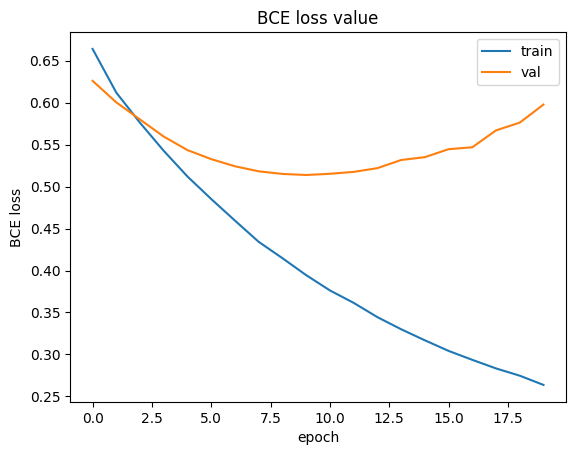

In [29]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Модель обучается, но как и без предобученных эмбеддингов в какой-то момент происходит переобучение. Loss на тестовой выборке снова начинает расти. Так что по сути, ситуация не меняется, и нет особой разницы, обучать эмбеддинг слой самостоятельно или брать готовые эмбеддинги.

### Попытка улучшить модель 1
Попробую снова взять первую модель (без предобученных эмбеддингов, но взять маленький размер одного эмбеддинга (до этого я брала 180 - это примерно корень из размера словаря word2id; теперь попробую взять эмбеддинги размером 5). Возможно это спасет от переобучения.

In [30]:
model3 = CNN(len(word2id), 5)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model3 = model3.to(DEVICE)
criterion = criterion.to(DEVICE)

In [31]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracies_eval = []
precisions = []
precisions_eval = []
recalls = []
recalls_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model3, train_iterator, optimizer3, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train, accuracy_on_train, precision_on_train, recall_on_train,_ = evaluate(model3, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    precisions.append(precision_on_train)
    recalls.append(recall_on_train)
    print('\nEvaluating on test...')
    f1_on_test, accuracy_on_test, precision_on_test, recall_on_test, epoch_loss_on_test = evaluate(model3, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracies_eval.append(accuracy_on_test)
    precisions_eval.append(precision_on_test)
    recalls_eval.append(recall_on_test)


starting Epoch 0
Training...
Train loss: 0.7653459385037422
Train loss: 0.7301801623720111
Train loss: 0.7179129743576049
Train loss: 0.711241582436348
Train loss: 0.7072939063821521

Evaluating on train...
Val loss: 0.7299639917910099, Val f1: 0.709339439868927, 
Val accuracy: 0.9680090546607971, Val precision: 0.5599786043167114, Val recall: 0.9680090546607971

Val loss: 0.7078279672246991, Val f1: 0.6842839121818542, 
Val accuracy: 0.9363110661506653, Val precision: 0.5393483638763428, Val recall: 0.9363110661506653

Val loss: 0.7005223250389099, Val f1: 0.6787593960762024, 
Val accuracy: 0.9273651838302612, Val precision: 0.5355235934257507, Val recall: 0.9273651838302612

Val loss: 0.6971644839244102, Val f1: 0.6754658818244934, 
Val accuracy: 0.9228017926216125, Val precision: 0.5329264998435974, Val recall: 0.9228017926216125

Val loss: 0.6952692646355856, Val f1: 0.6732805967330933, 
Val accuracy: 0.9202463030815125, Val precision: 0.5310658812522888, Val recall: 0.92024630308


Evaluating on test...
Val loss: 1.2672479748725891, Val f1: 1.222292184829712, 
Val accuracy: 1.1130603551864624, Val precision: 1.3553873300552368, Val recall: 1.1130603551864624

Val loss: 0.8445214827855428, Val f1: 0.8192111849784851, 
Val accuracy: 0.7541384696960449, Val precision: 0.8972411751747131, Val recall: 0.7541384696960449

Val loss: 0.7615922808647155, Val f1: 0.7392991185188293, 
Val accuracy: 0.6884918212890625, Val precision: 0.799118161201477, Val recall: 0.6884918212890625

Val loss: 0.7267164077077594, Val f1: 0.7037218809127808, 
Val accuracy: 0.6546460390090942, Val precision: 0.7614321708679199, Val recall: 0.6546460390090942

Val loss: 0.7083522015147738, Val f1: 0.680809736251831, 
Val accuracy: 0.6324832439422607, Val precision: 0.7377426028251648, Val recall: 0.6324832439422607


starting Epoch 5
Training...
Train loss: 0.6795428209006786
Train loss: 0.6539643713922212
Train loss: 0.645698823928833
Train loss: 0.6412185928714809
Train loss: 0.6373854499487

Train loss: 0.5923423099517823
Train loss: 0.5872749659552503
Train loss: 0.5854785300436474

Evaluating on train...
Val loss: 0.610469002276659, Val f1: 0.7237602472305298, 
Val accuracy: 0.6640839576721191, Val precision: 0.7958225011825562, Val recall: 0.6640839576721191

Val loss: 0.5911363489700087, Val f1: 0.7001261711120605, 
Val accuracy: 0.6433091163635254, Val precision: 0.7686737179756165, Val recall: 0.6433091163635254

Val loss: 0.5841828203201294, Val f1: 0.6936816573143005, 
Val accuracy: 0.6373755931854248, Val precision: 0.7615124583244324, Val recall: 0.6373755931854248

Val loss: 0.5808115912907159, Val f1: 0.6902576684951782, 
Val accuracy: 0.6342372894287109, Val precision: 0.7576820254325867, Val recall: 0.6342372894287109

Val loss: 0.5793313611121405, Val f1: 0.6879891753196716, 
Val accuracy: 0.6320376992225647, Val precision: 0.755416214466095, Val recall: 0.6320376992225647


Evaluating on test...
Val loss: 1.1780751943588257, Val f1: 1.314399242401123, 
Val 


Evaluating on test...
Val loss: 1.123540461063385, Val f1: 1.4086527824401855, 
Val accuracy: 1.3656482696533203, Val precision: 1.454698085784912, Val recall: 1.3656482696533203

Val loss: 0.747500479221344, Val f1: 0.9422257542610168, 
Val accuracy: 0.9202534556388855, Val precision: 0.9655405879020691, Val recall: 0.9202534556388855

Val loss: 0.675134253501892, Val f1: 0.8426998257637024, 
Val accuracy: 0.832182765007019, Val precision: 0.8541110754013062, Val recall: 0.832182765007019

Val loss: 0.6455116868019104, Val f1: 0.8055800199508667, 
Val accuracy: 0.7952121496200562, Val precision: 0.8166693449020386, Val recall: 0.7952121496200562

Val loss: 0.6305619478225708, Val f1: 0.7796370983123779, 
Val accuracy: 0.7711235284805298, Val precision: 0.7887488603591919, Val recall: 0.7711235284805298


starting Epoch 14
Training...
Train loss: 0.5617231391370296
Train loss: 0.545724711634896
Train loss: 0.5399043345451355
Train loss: 0.5368075157279399
Train loss: 0.535403488647370

Train loss: 0.5066952258348465
Train loss: 0.5013955835975817
Train loss: 0.5000615425053097

Evaluating on train...
Val loss: 0.5213297586888075, Val f1: 0.8231984972953796, 
Val accuracy: 0.8239181041717529, Val precision: 0.8229566216468811, Val recall: 0.8239181041717529

Val loss: 0.5054884074312268, Val f1: 0.7989593148231506, 
Val accuracy: 0.8002527952194214, Val precision: 0.7980203628540039, Val recall: 0.8002527952194214

Val loss: 0.5009949862957, Val f1: 0.7888731956481934, 
Val accuracy: 0.7924644947052002, Val precision: 0.7856183648109436, Val recall: 0.7924644947052002

Val loss: 0.4989710432379993, Val f1: 0.7848669290542603, 
Val accuracy: 0.7873162627220154, Val precision: 0.7827048897743225, Val recall: 0.7873162627220154

Val loss: 0.49721906050330117, Val f1: 0.7831443548202515, 
Val accuracy: 0.7867869138717651, Val precision: 0.7798193693161011, Val recall: 0.7867869138717651


Evaluating on test...
Val loss: 1.0814744234085083, Val f1: 1.4307876825332642, 
Val

In [32]:
print(losses, '\n\n', losses_eval)

[0.6987037177790295, 0.6851330426606265, 0.6731990975412455, 0.6595241921869192, 0.6447184925729578, 0.6294144872914661, 0.6151657239957289, 0.6029240908947858, 0.5905862504785712, 0.5786392383954742, 0.5673167461698706, 0.5564839839935303, 0.5470268699255857, 0.5376644615422596, 0.5288660079240799, 0.5184444961222735, 0.5110819227993488, 0.5018269815905527, 0.4947109215638854, 0.4876943257721988] 

 [0.6871046364307404, 0.676053810119629, 0.6636094450950623, 0.6487332463264466, 0.6375169813632965, 0.6256202757358551, 0.6160922229290009, 0.6079043209552765, 0.5984973669052124, 0.5935553669929504, 0.5852738678455353, 0.5783376693725586, 0.5730078876018524, 0.5675057530403137, 0.5638369977474212, 0.5585294842720032, 0.5543286919593811, 0.5511717021465301, 0.5480749726295471, 0.5434054493904114]


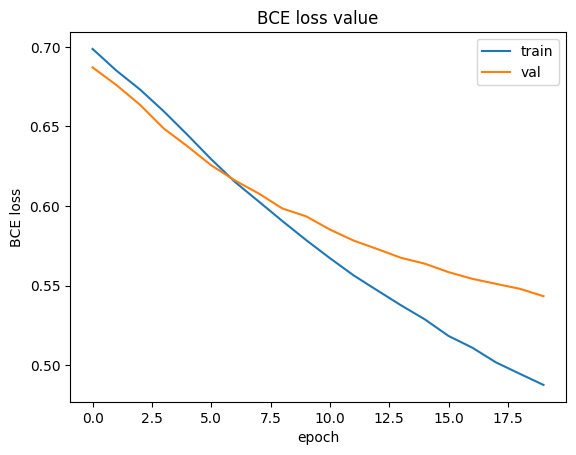

In [33]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Кажется, уменьшение размера эмбеддинга помогло избежать переобучения. Понятно, что losses у обучающей и тестовой выборки по-любому будут разными. Однако в данном случае, нет такого сильного различия, как у первых 2 моделей. На 20 эпохе loss обучающей выборки примерно 0.499, а тестовой - примерно 0.54. Поэтому можно сказать, что качество модели можно улучшить, работая с гиперпараметрами.

### Предсказания 

Попытаемся по лучшей из имеющихся моделей сделать предсказания на тестовой выборке и посмотрим на false positive и false negative.

In [34]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [35]:
fp, fn, tp, tn = predict(model3, val_iterator)

print('True positive: \n', tp[:20], '\n\n')
print('True negative: \n', tn[:20], '\n\n')
print('False positive: \n', fp[:20], '\n\n')
print('False negative: \n', fn[:20], '\n\n')

True positive: 
 ['5559116951342 на ребус и', 'rt и не не бумажки с меня на спину одноклассникам d', 'это анна то есть она тип но уже редко', 'хах если в следующий раз будет такой тебе все возможно', 'ван — ути знать кто бы это', 'космос 10 до дома скучаю по всем пишите звоните отвечу по возможности всем', 'прочитав этот статус вы лето на 5 секунд', 'hell__silence в лс напишу только насчёт др не забыть бы', 'сегодня я села на автобус и поняла что совсем не знаю города d', 'katerinanews хотя я в его возрасте не был от старшеклассников такое своего рода', 'у вас замечательные ночи', 'rt tukvasociopat коммунальные службы киева отлично работают без участия а.попова євромайдан http://t.co/vivqjkz6hv', 'rt по н.в это пипец ааааааааааа лучшее резюме из тех что я виде http://t.c…', 'я тут есть смотри видосы', 'ооооо спасибо большое так приятно ты первый 3 люблю', 'если бы я записывала все свои и косяки в книгу например то она уже была бы вот такой d', 'rt happybirthdaytrecool мужику стукнул го

#### Немножко анализа 
Наверное, это довольно очевидный факт, но твиты могут определяться моделью как негативные (ошибочно определяться), если в них есть частица "не". Видимо, "не" - является одним из основных признаков негативного твита, хотя в реальности "не" может употребляться где угодно.

Честно говоря, с false positive труднее. Возможно, влиет появление слов с положительной оценкой, таких как: "люблю", "радость", "классно" и тд. Или такие штуки, которые выражают какую-то положительную реакцию... типа "ахахахаха".

## Архитектура II

Каждый текст препроцессим, склеиваем все тексты в одну строку, а дальше делаем словарь из уникальных символов и словарь уникальных символов, встретившихся больше 5 раз

In [36]:
vocab_sym = Counter()
tweets_data_for_sym = tweets_data.text.apply(lambda x: ' '.join(preprocess(x)))
for symbol in tweets_data_for_sym:
    vocab_sym.update(list(symbol))
print('всего уникальных символов:', len(vocab_sym))

всего уникальных символов: 295


In [37]:
filtered_vocab_sym = set()

for symbol in vocab_sym:
    if vocab_sym[symbol] > 5:
        filtered_vocab_sym.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab_sym))

уникальных символов, втретившихся больше 5 раз: 141


Создаем словарь symbol2id и обратный ему

In [38]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
symbol2id = {'PAD':0}

for symbol in filtered_vocab_sym:
    symbol2id[symbol] = len(symbol2id)

In [39]:
#обратный словарь для того, чтобы раскодировать последовательность
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [40]:
print(len(symbol2id))

142


### Приводим данные в тот вид, в котором их можно будет подать в модель
Создаем класс, наследующий у Dataset

In [41]:
tweets_data['sym_texts'] = tweets_data_for_sym

In [42]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [43]:
class Sym_Word_TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['sym_texts'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        symbols = list(self.dataset[index])
        sym_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        
        tokens = self.preprocess(self.dataset[index]) # токенизируем
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return sym_ids, word_ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        sym_ids, word_ids, y = list(zip(*batch))
        padded_sym_ids = pad_sequence(sym_ids, batch_first=True).to(self.device)
        padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
        #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
        y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
        return padded_sym_ids, padded_word_ids, y

Для обучающей и для тестовой выборки создаем экземпляры Dataset (точнее того, класса, который наследует от него) и DataLoader

In [44]:
train_dataset = Sym_Word_TweetsDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [45]:
val_dataset = Sym_Word_TweetsDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

### Создаем саму модель

In [46]:
class Sym_Word_CNN(nn.Module):
    
    def __init__(self, sym_vocab_size, word_vocab_size, sym_embedding_dim, word_embedding_dim):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding_word = nn.Embedding(word_vocab_size, word_embedding_dim)
        self.linear_words = nn.Linear(in_features=word_embedding_dim, out_features=100)
        
        self.embedding_sym = nn.Embedding(sym_vocab_size, sym_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=sym_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=sym_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.linear_sym = nn.Linear(in_features=180, out_features=100)
        
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()
        
        
    def forward(self, sym_texts, word_texts): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        embedded_words = self.embedding_word(word_texts)   
        mean_embedded_words = torch.mean(embedded_words, dim=1)
        vec_words = self.dropout(self.relu(self.linear_words(mean_embedded_words)))
        
        embedded_sym = self.embedding_sym(sym_texts)
        embedded_sym = embedded_sym.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded_sym)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded_sym)))
        pooling_bi = feature_map_bigrams.max(2)[0]
        pooling_tri = feature_map_trigrams.max(2)[0]
        concat_sym = torch.cat((pooling_bi, pooling_tri), 1)
        vec_sym = self.linear_sym(concat_sym)
        
        concat = torch.cat((vec_words, vec_sym), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

### Модифицируем функции обучения и эвалюации

In [47]:
def train_II(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (sym_texts, words_texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(sym_texts, words_texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [48]:
def evaluate_II(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric_f1 = 0
    epoch_metric_precision = 0
    epoch_metric_recall = 0
    epoch_metric_accuracy = 0
    model.eval() 
    with torch.no_grad():
        for i, (sym_texts, words_texts, ys) in enumerate(iterator):   
            preds = model(sym_texts, words_texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric_f1 = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric_f1 += batch_metric_f1
            batch_metric_precision = precision(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric_precision += batch_metric_precision
            batch_metric_recall = recall(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric_recall += batch_metric_recall
            batch_metric_accuracy = accuracy(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric_accuracy += batch_metric_accuracy

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric_f1/i}, \nVal accuracy: {epoch_metric_accuracy/i}, Val precision: {epoch_metric_precision/i}, Val recall: {epoch_metric_recall/i}\n')
        
    return epoch_metric_f1 / len(iterator), epoch_metric_accuracy / len(iterator), epoch_metric_precision / len(iterator), epoch_metric_recall / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

Создаем экземпляр модели

In [52]:
model_II = Sym_Word_CNN(len(symbol2id), len(word2id), 5, 100)
optimizer_II = optim.Adam(model_II.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model_II = model_II.to(DEVICE)
criterion = criterion.to(DEVICE)

Запускаем обучение и эвалюацию модели (на 10 эпохах)

In [53]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracies_eval = []
precisions = []
precisions_eval = []
recalls = []
recalls_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train_II(model_II, train_iterator, optimizer_II, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train, accuracy_on_train, precision_on_train, recall_on_train,_ = evaluate_II(model_II, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    precisions.append(precision_on_train)
    recalls.append(recall_on_train)
    print('\nEvaluating on test...')
    f1_on_test, accuracy_on_test, precision_on_test, recall_on_test, epoch_loss_on_test = evaluate_II(model_II, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracies_eval.append(accuracy_on_test)
    precisions_eval.append(precision_on_test)
    recalls_eval.append(recall_on_test)


starting Epoch 0
Training...
Train loss: 0.7853158675134182
Train loss: 0.7363376490997545
Train loss: 0.7164020836353302
Train loss: 0.7034204646722594
Train loss: 0.6944403449694315

Evaluating on train...
Val loss: 0.7005071006715298, Val f1: 0.5977252125740051, 
Val accuracy: 0.5158455967903137, Val precision: 0.7117050886154175, Val recall: 0.5158455967903137

Val loss: 0.6788859547990741, Val f1: 0.574823796749115, 
Val accuracy: 0.49596261978149414, Val precision: 0.6849884986877441, Val recall: 0.49596261978149414

Val loss: 0.6717440032958985, Val f1: 0.5672608017921448, 
Val accuracy: 0.4882849454879761, Val precision: 0.6779254078865051, Val recall: 0.4882849454879761

Val loss: 0.6688944368220088, Val f1: 0.5629779696464539, 
Val accuracy: 0.4850606918334961, Val precision: 0.6718699336051941, Val recall: 0.4850606918334961

Val loss: 0.6672593241646176, Val f1: 0.5601361989974976, 
Val accuracy: 0.48295673727989197, Val precision: 0.6677235960960388, Val recall: 0.4829567


Evaluating on test...
Val loss: 1.0324949026107788, Val f1: 1.4444901943206787, 
Val accuracy: 1.3340647220611572, Val precision: 1.5754756927490234, Val recall: 1.3340647220611572

Val loss: 0.6912742654482523, Val f1: 0.9540538787841797, 
Val accuracy: 0.8865298628807068, Val precision: 1.0331329107284546, Val recall: 0.8865298628807068

Val loss: 0.6255768775939942, Val f1: 0.8552337884902954, 
Val accuracy: 0.7898663282394409, Val precision: 0.9329781532287598, Val recall: 0.7898663282394409

Val loss: 0.598441583769662, Val f1: 0.81400066614151, 
Val accuracy: 0.749912679195404, Val precision: 0.8905627131462097, Val recall: 0.749912679195404

Val loss: 0.5799742672178481, Val f1: 0.7922370433807373, 
Val accuracy: 0.7288650870323181, Val precision: 0.8680815696716309, Val recall: 0.7288650870323181


starting Epoch 5
Training...
Train loss: 0.49773837625980377
Train loss: 0.48586268858476117
Train loss: 0.4770907199382782
Train loss: 0.47292525243403305
Train loss: 0.46963233571

Train loss: 0.38611936207973596
Train loss: 0.38230785727500916
Train loss: 0.38120602404893333
Train loss: 0.3812904453703335

Evaluating on train...
Val loss: 0.4007279071956873, Val f1: 0.873281717300415, 
Val accuracy: 0.7981586456298828, Val precision: 0.9644042253494263, Val recall: 0.7981586456298828

Val loss: 0.3876509892218041, Val f1: 0.8478496670722961, 
Val accuracy: 0.7738270163536072, Val precision: 0.9378848671913147, Val recall: 0.7738270163536072

Val loss: 0.3848141783475876, Val f1: 0.8387451171875, 
Val accuracy: 0.7663498520851135, Val precision: 0.9266040921211243, Val recall: 0.7663498520851135

Val loss: 0.3828718737879796, Val f1: 0.8340103626251221, 
Val accuracy: 0.7609024047851562, Val precision: 0.9230526685714722, Val recall: 0.7609024047851562

Val loss: 0.38313186913728714, Val f1: 0.8312374949455261, 
Val accuracy: 0.7580516934394836, Val precision: 0.920468270778656, Val recall: 0.7580516934394836


Evaluating on test...
Val loss: 0.9977782964706421, 

In [54]:
print(losses, '\n\n', losses_eval)

[0.6852426407012072, 0.6346949501471086, 0.5873468897559426, 0.5395162559368394, 0.4966728057373654, 0.4637072055854581, 0.43528044426983054, 0.4147061597217213, 0.3924485556781292, 0.3765388571403243] 

 [0.6614657521247864, 0.6280522525310517, 0.5876662254333496, 0.5464789927005768, 0.5219768404960632, 0.5035303264856339, 0.505085751414299, 0.4959722191095352, 0.4908071607351303, 0.5027923226356507]


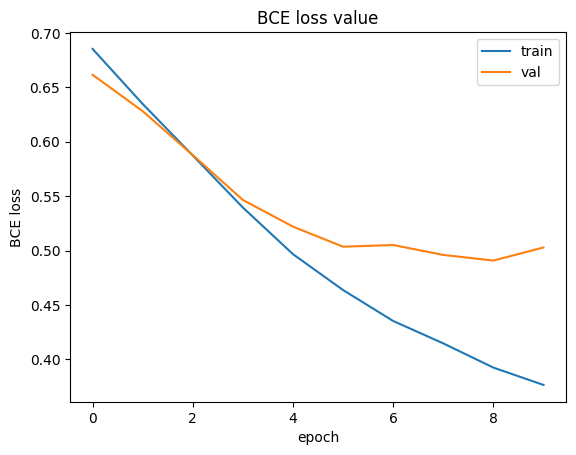

In [55]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Модель обучалась, но произошло переобучение, нужно попробовать уменьшить размер эмбеддинга для слов (в смысле предложений, в смысле не символов); в первой части дз это помогло спастись от переобучения

Создадим новый экземпляр модели

In [56]:
model_II_1 = Sym_Word_CNN(len(symbol2id), len(word2id), 5, 5)
optimizer_II_1 = optim.Adam(model_II_1.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model_II_1 = model_II_1.to(DEVICE)
criterion = criterion.to(DEVICE)

Запускаем процесс обучения и эвалюации

In [57]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracies_eval = []
precisions = []
precisions_eval = []
recalls = []
recalls_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train_II(model_II_1, train_iterator, optimizer_II_1, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train, accuracy_on_train, precision_on_train, recall_on_train,_ = evaluate_II(model_II_1, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    precisions.append(precision_on_train)
    recalls.append(recall_on_train)
    print('\nEvaluating on test...')
    f1_on_test, accuracy_on_test, precision_on_test, recall_on_test, epoch_loss_on_test = evaluate_II(model_II_1, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracies_eval.append(accuracy_on_test)
    precisions_eval.append(precision_on_test)
    recalls_eval.append(recall_on_test)


starting Epoch 0
Training...
Train loss: 0.767481803894043
Train loss: 0.7266309893492496
Train loss: 0.7103517973423004
Train loss: 0.7010112422615734
Train loss: 0.6938415652229672

Evaluating on train...
Val loss: 0.7075648717582226, Val f1: 0.6965221762657166, 
Val accuracy: 0.7468907833099365, Val precision: 0.6530520915985107, Val recall: 0.7468907833099365

Val loss: 0.6869421583233457, Val f1: 0.6755457520484924, 
Val accuracy: 0.7312424182891846, Val precision: 0.6282314658164978, Val recall: 0.7312424182891846

Val loss: 0.6799516761302948, Val f1: 0.668129563331604, 
Val accuracy: 0.7228049635887146, Val precision: 0.62163907289505, Val recall: 0.7228049635887146

Val loss: 0.6766171535449241, Val f1: 0.6655403971672058, 
Val accuracy: 0.7202644944190979, Val precision: 0.6190130710601807, Val recall: 0.7202644944190979

Val loss: 0.6748355002630324, Val f1: 0.6624773740768433, 
Val accuracy: 0.7165154218673706, Val precision: 0.6164655685424805, Val recall: 0.7165154218673


Evaluating on test...
Val loss: 1.2442547082901, Val f1: 1.4141818284988403, 
Val accuracy: 1.7320151329040527, Val precision: 1.1949667930603027, Val recall: 1.7320151329040527

Val loss: 0.8225069443384806, Val f1: 0.9575324058532715, 
Val accuracy: 1.1731059551239014, Val precision: 0.8089280128479004, Val recall: 1.1731059551239014

Val loss: 0.7391536712646485, Val f1: 0.8583294153213501, 
Val accuracy: 1.0458462238311768, Val precision: 0.7279370427131653, Val recall: 1.0458462238311768

Val loss: 0.7032593233244759, Val f1: 0.8156152963638306, 
Val accuracy: 0.989227294921875, Val precision: 0.694114089012146, Val recall: 0.989227294921875

Val loss: 0.6831303636233012, Val f1: 0.7922312617301941, 
Val accuracy: 0.9609721302986145, Val precision: 0.674117386341095, Val recall: 0.9609721302986145


starting Epoch 5
Training...
Train loss: 0.6325195357203484
Train loss: 0.6113936232798027
Train loss: 0.6051615071296692
Train loss: 0.5983929482858572
Train loss: 0.5933751407123747

Train loss: 0.5435563743114471
Train loss: 0.5403143274250315
Train loss: 0.5389096545321601

Evaluating on train...
Val loss: 0.5539150629192591, Val f1: 0.7853317260742188, 
Val accuracy: 0.7718481421470642, Val precision: 0.7996358871459961, Val recall: 0.7718481421470642

Val loss: 0.5353766399802584, Val f1: 0.7678327560424805, 
Val accuracy: 0.7538966536521912, Val precision: 0.7826194167137146, Val recall: 0.7538966536521912

Val loss: 0.5313687306642533, Val f1: 0.7585399150848389, 
Val accuracy: 0.742398738861084, Val precision: 0.775719165802002, Val recall: 0.742398738861084

Val loss: 0.5290772421146507, Val f1: 0.7540675401687622, 
Val accuracy: 0.7385045886039734, Val precision: 0.770641028881073, Val recall: 0.7385045886039734

Val loss: 0.5276185419587862, Val f1: 0.7523576617240906, 
Val accuracy: 0.736931562423706, Val precision: 0.7687885761260986, Val recall: 0.736931562423706


Evaluating on test...
Val loss: 1.0956449508666992, Val f1: 1.4340035915374756, 
Val acc

In [58]:
print(losses, '\n\n', losses_eval)

[0.6846612861210649, 0.644481014798988, 0.6237530891190876, 0.6092340641401031, 0.5969476185061715, 0.5857567651705309, 0.5704439831050959, 0.5570245778018778, 0.5418739014051177, 0.5323940854180943] 

 [0.6683606147766114, 0.6406097054481507, 0.6274025976657868, 0.61476371884346, 0.614817327260971, 0.5895536661148071, 0.5775668859481812, 0.565792840719223, 0.5537235617637635, 0.5461918234825134]


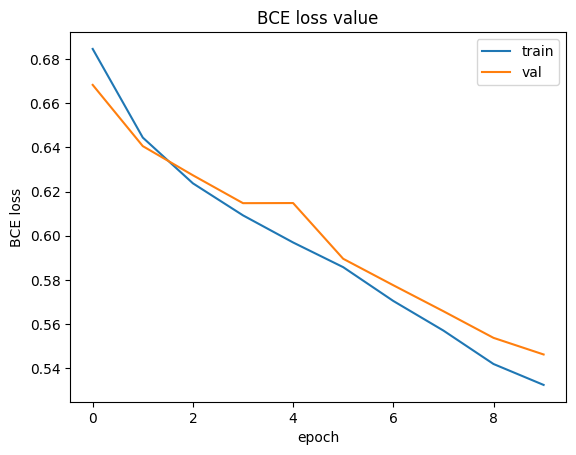

In [59]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Кажется, действительно, помогло. С таким размером эмбеддинга переобучение не происходит

### Ещё одна попытка улучшения модели

Можно попробовать кроме размера эмбеддинга менять ещё количество фильтров на сверточном слое. Я не уверена, что это ощутимо улучшит модель, но возможно появятся какие-то изменения

In [60]:
class Sym_Word_CNN_2(nn.Module):
    
    def __init__(self, sym_vocab_size, word_vocab_size, sym_embedding_dim, word_embedding_dim):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding_word = nn.Embedding(word_vocab_size, word_embedding_dim)
        self.linear_words = nn.Linear(in_features=word_embedding_dim, out_features=100)
        
        self.embedding_sym = nn.Embedding(sym_vocab_size, sym_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=sym_embedding_dim, out_channels=60, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=sym_embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.linear_sym = nn.Linear(in_features=160, out_features=100)
        
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()
        
        
    def forward(self, sym_texts, word_texts): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        embedded_words = self.embedding_word(word_texts)   
        mean_embedded_words = torch.mean(embedded_words, dim=1)
        vec_words = self.dropout(self.relu(self.linear_words(mean_embedded_words)))
        
        embedded_sym = self.embedding_sym(sym_texts)
        embedded_sym = embedded_sym.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded_sym)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded_sym)))
        pooling_bi = feature_map_bigrams.max(2)[0]
        pooling_tri = feature_map_trigrams.max(2)[0]
        concat_sym = torch.cat((pooling_bi, pooling_tri), 1)
        vec_sym = self.linear_sym(concat_sym)
        
        concat = torch.cat((vec_words, vec_sym), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

Создаем экземпляр новой модели

In [61]:
model_II_2 = Sym_Word_CNN_2(len(symbol2id), len(word2id), 5, 5)
optimizer_II_2 = optim.Adam(model_II_2.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model_II_2 = model_II_2.to(DEVICE)
criterion = criterion.to(DEVICE)

Запускаем обучение и эвалюацию

In [62]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracies_eval = []
precisions = []
precisions_eval = []
recalls = []
recalls_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train_II(model_II_2, train_iterator, optimizer_II_2, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train, accuracy_on_train, precision_on_train, recall_on_train,_ = evaluate_II(model_II_2, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    precisions.append(precision_on_train)
    recalls.append(recall_on_train)
    print('\nEvaluating on test...')
    f1_on_test, accuracy_on_test, precision_on_test, recall_on_test, epoch_loss_on_test = evaluate_II(model_II_2, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracies_eval.append(accuracy_on_test)
    precisions_eval.append(precision_on_test)
    recalls_eval.append(recall_on_test)


starting Epoch 0
Training...
Train loss: 0.7503871470689774
Train loss: 0.7181244546716864
Train loss: 0.7064299786090851
Train loss: 0.698988816631374
Train loss: 0.693071403673717

Evaluating on train...
Val loss: 0.7118953354656696, Val f1: 0.5615872144699097, 
Val accuracy: 0.4794451594352722, Val precision: 0.6782313585281372, Val recall: 0.4794451594352722

Val loss: 0.6922321337642092, Val f1: 0.5409793257713318, 
Val accuracy: 0.4576210379600525, Val precision: 0.6625388860702515, Val recall: 0.4576210379600525

Val loss: 0.6861367201805115, Val f1: 0.5305320620536804, 
Val accuracy: 0.448685884475708, Val precision: 0.6499353051185608, Val recall: 0.448685884475708

Val loss: 0.6831021887152943, Val f1: 0.5248467326164246, 
Val accuracy: 0.4424300789833069, Val precision: 0.6460679173469543, Val recall: 0.4424300789833069

Val loss: 0.6811212315445855, Val f1: 0.5233729481697083, 
Val accuracy: 0.4410155713558197, Val precision: 0.6445882320404053, Val recall: 0.4410155713558


Evaluating on test...
Val loss: 1.217857301235199, Val f1: 1.3621604442596436, 
Val accuracy: 1.378676176071167, Val precision: 1.3466887474060059, Val recall: 1.378676176071167

Val loss: 0.8004948298136393, Val f1: 0.9297900199890137, 
Val accuracy: 0.9413805603981018, Val precision: 0.918743908405304, Val recall: 0.9413805603981018

Val loss: 0.7204440355300903, Val f1: 0.8296210169792175, 
Val accuracy: 0.8337224125862122, Val precision: 0.8261780738830566, Val recall: 0.8337224125862122

Val loss: 0.6869816269193377, Val f1: 0.7912362217903137, 
Val accuracy: 0.7939532399177551, Val precision: 0.78919517993927, Val recall: 0.7939532399177551

Val loss: 0.6672023402320014, Val f1: 0.7663345336914062, 
Val accuracy: 0.7672980427742004, Val precision: 0.7659242153167725, Val recall: 0.7672980427742004


starting Epoch 5
Training...
Train loss: 0.6236697249114513
Train loss: 0.6026006991213019
Train loss: 0.5954839479923248
Train loss: 0.5911855635358326
Train loss: 0.588988803681873

Train loss: 0.5315395230054856
Train loss: 0.5276483279555592
Train loss: 0.525588102993511

Evaluating on train...
Val loss: 0.5400477536022663, Val f1: 0.8181555271148682, 
Val accuracy: 0.8503327965736389, Val precision: 0.7885767221450806, Val recall: 0.8503327965736389

Val loss: 0.5250509877999624, Val f1: 0.7911138534545898, 
Val accuracy: 0.8236850500106812, Val precision: 0.7612838745117188, Val recall: 0.8236850500106812

Val loss: 0.520243347287178, Val f1: 0.7815074920654297, 
Val accuracy: 0.8117400407791138, Val precision: 0.7537071108818054, Val recall: 0.8117400407791138

Val loss: 0.5173861517835019, Val f1: 0.7762842774391174, 
Val accuracy: 0.8078098893165588, Val precision: 0.7474079132080078, Val recall: 0.8078098893165588

Val loss: 0.5159418934157917, Val f1: 0.7735711932182312, 
Val accuracy: 0.8041048645973206, Val precision: 0.745534360408783, Val recall: 0.8041048645973206


Evaluating on test...
Val loss: 1.0940223336219788, Val f1: 1.4611716270446777, 
Val 

In [63]:
print(losses, '\n\n', losses_eval)

[0.6841534674167633, 0.6577381823550571, 0.6362857364795425, 0.616763523356481, 0.5982236909595403, 0.5822911343791268, 0.5674629346890883, 0.5493879270824519, 0.5343195189806548, 0.5187143954363737] 

 [0.6728095829486846, 0.6547228813171386, 0.6380456328392029, 0.6171266138553619, 0.6004821062088013, 0.5842971205711365, 0.5749543905258179, 0.5590234518051147, 0.5505291163921356, 0.5389683187007904]


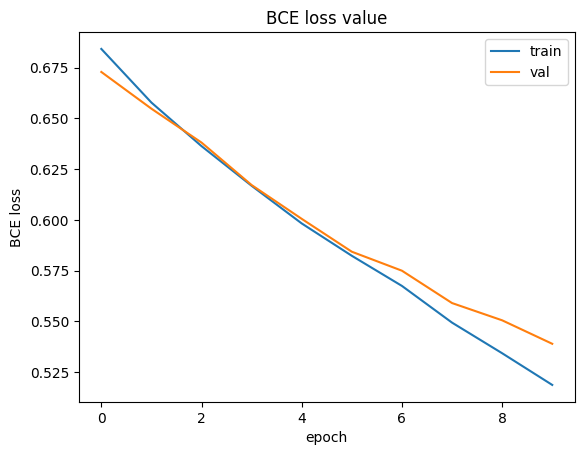

In [64]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Предсказания

Делаем предсказания на тестовой выборке, и пытаемся немного проанализировать false positive и false negative результаты

In [69]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (sym_texts, words_texts, ys) in enumerate(iterator):   
            preds = model(sym_texts, words_texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, words_texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [70]:
fp, fn, tp, tn = predict(model_II_2, val_iterator)

print('True positive: \n', tp[:20], '\n\n')
print('True negative: \n', tn[:20], '\n\n')
print('False positive: \n', fp[:20], '\n\n')
print('False negative: \n', fn[:20], '\n\n')

True positive: 
 ['rt ad666m the_dark_lord_7 проведем все вместе', 'heeartatack плять тожи что ли пойти хаха удачи малыш я тибе смс написал лал', 'не люблю я свое', 'ахахах d мажоры берут не d', 'давно не писала еще из новостей купили с котом по электронной книжке каждый обе лучшие в своем роде короче', 'ахаха класс я уверена что оно того стоит', 'liiiizka оо даа ми її d', 'rt jjangum оны шилдэг дандаа л юм гээд байдаг тодорлоо', 'poluhinamariy упоротый я в своем любимом прости за плохое качество это просто на переднюю камеру', 'главное чтобы каток залили а а остальном этот снег и не только если для снеговиков', 'rt как можно больше спасибо', 'я просто не ходила на физру с 1 сентября родителей вызвали в шк ахахах вот и наказали но я бывает захожу в и тд', 'rt обожаю успокаивает', 'rt друзья спасибо всем за поздравления очень приятно я приехала в городе всем огромный привет', 'я помню у нас в ванной весь пол меняли и потолок за 3 дня', 'приставки по всему предложению с о народе — этого 

### Небольшой итог

В целом, оба варианта моделей обучаются, с помощью работы с гиперпараметрами (такими как количество фильтров и размер эмбеддингов) удалось избежать переобучений. 
Получилось посмотреть на некоторые предсказания. Можно предположить то, что некоторые позитивные твиты могут считываться моделью как негативные в тех случаях, когда в них присутствует частица "не" или какие-то негативно эмоциональные слова. И, наоборот, негативные твиты могут восприниматься как позитивные, когда в них присутствуют слова с какой-то явно позитивной оценкой, вроде "любить", "классно" и тд. Это довольно очевидные вещи, но предсказания продемонстрировали это.

Однако в целом, можно заметить, что всё-таки loss у всех полученных моделей довольно велик, и ещё есть что улучшать. Возможно, можно было ещё попробовать не делать препроцессинг текстов (не убирать пунктуацию, не приводить к нижнему регистру). Можно предположить, что это бы улучшило качество модели. И возможно, позволило бы посмотреть, влияют ли как-то на предсказания различные знаки препинания, типа смайликов из скобочек и тд.